In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CaseName_Base = 'RTS24_mod1'

Folder_A = 'A.The_full_year_MILP'
Folder_B = 'B.Operation_cost'
Folder_D = 'D.Representative_days_based_on_RES_and_Demand'
Folder_E = 'E.Representative_days_based_on_Line_Benefits_OptModel'
Folder_K = 'K.Investments_per_hour'
Folder_L = 'L.Cont_Investments_per_hour'

DirName  = os.getcwd()
_path_0 = os.path.join(DirName, CaseName_Base)
category_dict = {Folder_A: "FYMILP",
                 Folder_B: "OPC",
                 Folder_D: "R&D",
                 Folder_E: "OPT_LB",
                 Folder_K: "Hourly_inv",
                 Folder_L: "CHI",

                }

In [3]:
def LoadingData(dir, folder,result, case, ncluster, cm,folder_out = "4.OutWoInv"):
    #If the folder is A, the name is slightly different (no ByStages in the name and not dependent on nb clust)
    if folder == 'A.The_full_year_MILP': 
        df = pd.read_csv(os.path.join(dir, folder, case, folder_out, f'oT_Result_{result}_'+case+'.csv'), index_col=[0,1])
    else: 
        df = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), folder_out, f'oT_Result_{result}_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'), index_col=[0,1])

    df['CaseName'] = folder + ' - ' + case + str(ncluster)
    df['Clustering method'] = cm
    df['Number of clusters'] = ncluster
    df = df.reset_index()

    return df

#Load the weights of the representative periods 
def LoadingWeights(dir, folder, case, ncluster):
    if folder == 'A.The_full_year_MILP': 
        df_stage = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Stage_'+case+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case, '2.Par', f'oT_Data_Duration_'+case+'.csv'))
    else: 
        df_stage = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Stage_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
        df_duration = pd.read_csv(os.path.join(dir, folder, case+'_ByStages_nc'+str(ncluster), '2.Par', f'oT_Data_Duration_'+case+ '_ByStages_nc'+str(ncluster)+'.csv'))
    durations_filtered = df_duration[df_duration['Duration'] == 1]
    merged_df = pd.merge(df_stage, durations_filtered, left_on='Unnamed: 0', right_on='Stage', how='left')

    return merged_df


In [4]:
nbs_clusters = [(i+1)*10 for i in range(10)] + [150, 200, 250, 300,350, 400]
#nbs_clusters = [(i+1)*10 for i in range(2)]

#folders = [Folder_JB, Folder_JD,Folder_JE,Folder_JL]#,Folder_E,Folder_F,Folder_G]
folders = [Folder_A,Folder_B,Folder_D,Folder_E,Folder_L,Folder_K]
#folders = [Folder_A,Folder_L,Folder_JL,Folder_D,Folder_JD,Folder_B,Folder_JB,Folder_E,Folder_JE]
results = ["NetworkFlowPerNode"]

results_dfs = dict()
weights_dfs = dict()
results_w_dfs = dict()
for result in results :
    results_dfs[result] = dict()
    weights_dfs[result] = dict()
    results_w_dfs[result] = dict()
    for folder in folders: 
        results_dfs[result][folder] = dict()
        results_w_dfs[result][folder] = dict()
        weights_dfs[result][folder] = dict()
        for nb_clusters in nbs_clusters:
            try: 
                results_dfs[result][folder][nb_clusters] = LoadingData(DirName, folder,result, CaseName_Base, nb_clusters, category_dict[folder])
                if not(folder.startswith("J")):
                    weights_dfs[result][folder][nb_clusters] = LoadingWeights(DirName,folder,CaseName_Base,nb_clusters)
                    results_w_dfs[result][folder][nb_clusters] = results_dfs[result][folder][nb_clusters].merge(weights_dfs[result][folder][nb_clusters][["LoadLevel","Weight"]],on= "LoadLevel")
                                        
            except FileNotFoundError as e : 
                print(e)
                print(folder,nb_clusters, "Does not contain", result)
def get_overall_avg_utilization(df_utilization): 
    return df_utilization["GWh"].mean()

def get_weighted_overall_avg_Utilization(df_util,df_weights):
    merged_df = df_util.merge(df_weights,how = "left",on = "LoadLevel")
    merged_df["GWh_weighted"] = merged_df["GWh"] * merged_df["Weight"]
    return merged_df["GWh_weighted"].sum()/merged_df["Weight"].sum()

In [5]:
# Initialize DataFrames to store results
overal_avg_flows = pd.DataFrame()
all_flows = pd.DataFrame()
i = 0

# Loop through each folder and number of clusters
for folder in folders:
    print(folder)
    for nb_clusters in nbs_clusters:
        # Calculate the overall average utilization
        overall_avg_util = get_overall_avg_utilization(results_dfs[result][folder][nb_clusters])
        
        # Calculate the weighted overall average utilization if necessary
        if folder.startswith("J."):
            overall_weighted_utilization = overall_avg_util
        else:
            overall_weighted_utilization = get_weighted_overall_avg_Utilization(
                results_dfs[result][folder][nb_clusters],
                weights_dfs[result][folder][nb_clusters]
            )
        
        # Create a new row with the calculated values
        row = pd.DataFrame({
            "Clustering method": category_dict[folder],
            "Number of clusters": nb_clusters,
            "Avg_util": overall_avg_util,
            "Avg_util_w": overall_weighted_utilization
        }, index=[i])
        i += 1
        
        # Concatenate the new row to the overall summary DataFrame
        overal_avg_flows = pd.concat([overal_avg_flows, row])
        
        # Concatenate the individual results to the all_utils DataFrame
        #all_utils = pd.concat([all_utils, results_dfs[result][folder][nb_clusters]])
        all_flows = pd.concat([all_flows, results_w_dfs[result][folder][nb_clusters]])

A.The_full_year_MILP
B.Operation_cost
D.Representative_days_based_on_RES_and_Demand
E.Representative_days_based_on_Line_Benefits_OptModel
L.Cont_Investments_per_hour
K.Investments_per_hour


In [6]:
all_flows

,Period,Scenario,LoadLevel,InitialNode,FinalNode,Circuit,GWh,CaseName,Clustering method,Number of clusters,Weight
0,2030,sc01,01-01 00:00:00+01:00,N_117,N_118,cac3,0.000000,A.The_full_year_MILP - RTS24_mod110,FYMILP,10,1
1,2030,sc01,01-01 00:00:00+01:00,N_117,N_122,eac1,0.001451,A.The_full_year_MILP - RTS24_mod110,FYMILP,10,1
2,2030,sc01,01-01 00:00:00+01:00,N_112,N_123,eac1,-0.043465,A.The_full_year_MILP - RTS24_mod110,FYMILP,10,1
3,2030,sc01,01-01 00:00:00+01:00,N_102,N_106,eac1,0.041005,A.The_full_year_MILP - RTS24_mod110,FYMILP,10,1
4,2030,sc01,01-01 00:00:00+01:00,N_106,N_108,cac2,0.000000,A.The_full_year_MILP - RTS24_mod110,FYMILP,10,1
...,...,...,...,...,...,...,...,...,...,...,...
21995,2030,sc01,12-30 09:00:00+01:00,N_118,N_121,cac2,0.000000,K.Investments_per_hour - RTS24_mod1400,Hourly_inv,400,2
21996,2030,sc01,12-30 09:00:00+01:00,N_114,N_116,eac1,-0.251121,K.Investments_per_hour - RTS24_mod1400,Hourly_inv,400,2
21997,2030,sc01,12-30 09:00:00+01:00,N_116,N_117,cac3,0.000000,K.Investments_per_hour - RTS24_mod1400,Hourly_inv,400,2
21998,2030,sc01,12-30 09:00:00+01:00,N_117,N_122,eac1,-0.260824,K.Investments_per_hour - RTS24_mod1400,Hourly_inv,400,2


In [7]:
all_flows["Weighted GWh"] = all_flows["GWh"] * all_flows["Weight"]

In [17]:
filtered_flows = all_flows[all_flows["Number of clusters"] == 30]


filtered_flows.pivot_table(index = ["InitialNode","FinalNode"],
                           values = "GWh",
                           columns = ["Clustering method"],
                           aggfunc="min")

Clustering method           CHI    FYMILP  Hourly_inv       OPC    OPT_LB   
InitialNode FinalNode                                                       
N_101       N_102     -0.121835 -0.155772   -0.076613 -0.112487 -0.128272  \
            N_103     -0.046396 -0.098641   -0.056523 -0.085931 -0.069610   
            N_105     -0.016340 -0.035056   -0.009406 -0.017073  0.008138   
N_102       N_104     -0.063288 -0.077991   -0.066337 -0.068275 -0.055328   
            N_106     -0.008237 -0.020206   -0.003598 -0.008111  0.006693   
N_103       N_109     -0.026467 -0.062517   -0.011243  0.001227 -0.019026   
            N_124     -0.175000 -0.175000   -0.175000 -0.175000 -0.175000   
N_104       N_109     -0.053148 -0.067281   -0.057860 -0.055818 -0.038829   
N_105       N_110     -0.060710 -0.065764   -0.046114 -0.052169 -0.035428   
N_106       N_108      0.000000  0.000000    0.000000  0.000000  0.000000   
            N_110     -0.087674 -0.107994   -0.092414 -0.083906 -0.090403   
N_107       N_108     -0.080233 -0.115242   -0.053428 -0.091587 -0.080580   
N_108       N_109     -0.091096 -0.137622   -0.093846 -0.112281 -0.109615   
            N_110     -0.070041 -0.091689   -0.068568 -0.079680 -0.076530   
N_109       N_111     -0.092321 -0.107623   -0.077944 -0.070833 -0.088059   
            N_112     -0.085378 -0.126949   -0.086692 -0.081724 -0.085718   
N_110       N_111     -0.137886 -0.185059   -0.133948 -0.125825 -0.150036   
            N_112     -0.130942 -0.177720   -0.132557 -0.129580 -0.121603   
N_111       N_113     -0.165399 -0.175528   -0.141115 -0.132690 -0.152988   
            N_114     -0.212135 -0.216000   -0.209654 -0.177911 -0.208410   
N_112       N_113     -0.121240 -0.157178   -0.117089 -0.125673 -0.110424   
            N_123     -0.200918 -0.212229   -0.204102 -0.200922 -0.200405   
N_113       N_123     -0.220000 -0.220000   -0.220000 -0.220000 -0.220000   
N_114       N_116     -0.345220 -0.353403   -0.341269 -0.341501 -0.342357   
N_115       N_116     -0.088913 -0.195392   -0.068288 -0.094635 -0.111869   
            N_121     -0.175000 -0.175000   -0.175000 -0.175000 -0.175000   
            N_124     -0.061149 -0.152358   -0.094897 -0.058999 -0.050108   
N_116       N_117     -0.319543 -0.348409   -0.343240 -0.329264 -0.332395   
            N_119     -0.238055 -0.275491   -0.191665 -0.127213 -0.223162   
N_117       N_118     -0.191482 -0.226721   -0.180161 -0.198218 -0.159903   
            N_122     -0.328832 -0.346111   -0.302540 -0.309939 -0.292050   
N_118       N_121     -0.244341 -0.289341   -0.237819 -0.264403 -0.262621   
N_119       N_120     -0.063369 -0.127859   -0.088531 -0.100594 -0.036271   
N_120       N_123     -0.179606 -0.244238   -0.181693 -0.191070 -0.154570   
N_121       N_122     -0.419341 -0.442781   -0.400034 -0.397719 -0.386958   

Clustering method           R&D  
InitialNode FinalNode            
N_101       N_102     -0.124122  
            N_103     -0.048528  
            N_105     -0.006232  
N_102       N_104     -0.061665  
            N_106     -0.003208  
N_103       N_109     -0.034956  
            N_124     -0.175000  
N_104       N_109     -0.061659  
N_105       N_110     -0.057386  
N_106       N_108      0.000000  
            N_110     -0.082011  
N_107       N_108     -0.073421  
N_108       N_109     -0.099221  
            N_110     -0.072726  
N_109       N_111     -0.087167  
            N_112     -0.091480  
N_110       N_111     -0.118914  
            N_112     -0.123227  
N_111       N_113     -0.142697  
            N_114     -0.186615  
N_112       N_113     -0.106134  
            N_123     -0.202844  
N_113       N_123     -0.220000  
N_114       N_116     -0.263174  
N_115       N_116     -0.103651  
            N_121     -0.175000  
            N_124     -0.102163  
N_116       N_117     -0.305776  
            N_119     -0.216738  
N_117       N_118     -0.202294  
            N_122     -0.277191  
N_118       N_121     -0.229

<Axes: xlabel='InitialNode,FinalNode'>

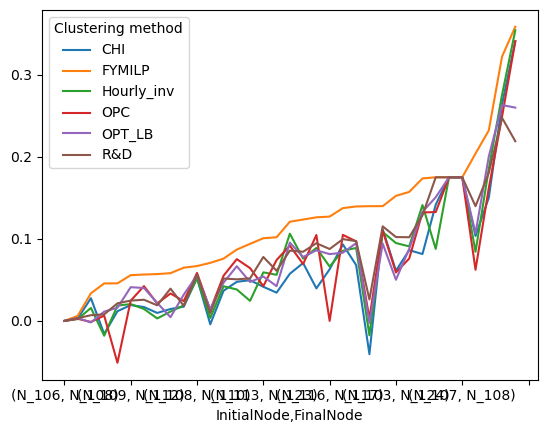

In [18]:
col = "GWh"
agg_func = "max"
pivot_table = filtered_flows.pivot_table(index = ["InitialNode","FinalNode"],
                           values = col,
                           columns = ["Clustering method"],
                           aggfunc=agg_func).sort_values("FYMILP")
pivot_table.plot()

<Axes: xlabel='InitialNode,FinalNode'>

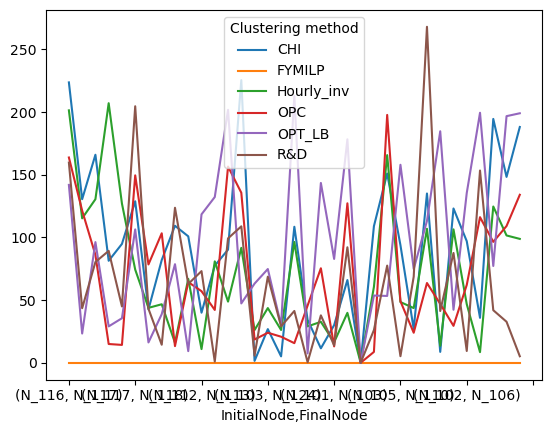

In [19]:
col = "Weighted GWh"
agg_func = "sum"
pivot_table = filtered_flows.pivot_table(index = ["InitialNode","FinalNode"],
                           values = col,
                           columns = ["Clustering method"],
                           aggfunc=agg_func).sort_values("FYMILP")
deviation_table =  pivot_table.subtract(pivot_table["FYMILP"], axis=0)
deviation_table.abs().plot()

In [20]:
deviation_table.abs().sum()

Clustering method
CHI           3188.304115
FYMILP           0.000000
Hourly_inv    2497.167332
OPC           2478.677176
OPT_LB        3356.178157
R&D           2255.075426
dtype: float64

In [15]:
results_dfs["NetworkFlowPerNode"]["A.The_full_year_MILP"][10].pivot_table(index = "InitialNode",values = "GWh",columns = "FinalNode",aggfunc="sum")

FinalNode,N_102,N_103,N_104,N_105,N_106,N_108,N_109,N_110,N_111,N_112,...,N_114,N_116,N_117,N_118,N_119,N_120,N_121,N_122,N_123,N_124
InitialNode,,,,,,,,,,,,,,,,,,,,,
N_101,20.391543,-79.729995,NaN,452.127752,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_102,NaN,NaN,2.71367,NaN,337.0509,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_103,NaN,NaN,NaN,NaN,NaN,NaN,372.140300,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-190.970662
N_104,NaN,NaN,NaN,NaN,NaN,NaN,258.615780,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.602275,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_106,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-198.233706,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_107,NaN,NaN,NaN,NaN,NaN,369.834603,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_108,NaN,NaN,NaN,NaN,NaN,NaN,-220.794683,-65.989381,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-139.400003,-163.637559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
results_dfs["NetworkFlowPerNode"]["B.Operation_cost"][10].pivot_table(index = "InitialNode",values = "GWh",columns = "FinalNode",aggfunc="sum")

FinalNode,N_102,N_103,N_104,N_105,N_106,N_108,N_109,N_110,N_111,N_112,...,N_114,N_116,N_117,N_118,N_119,N_120,N_121,N_122,N_123,N_124
InitialNode,,,,,,,,,,,,,,,,,,,,,
N_101,0.310231,-0.048724,NaN,0.72381,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_102,NaN,NaN,0.095199,NaN,0.528856,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_103,NaN,NaN,NaN,NaN,NaN,NaN,0.489571,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.596019
N_104,NaN,NaN,NaN,NaN,NaN,NaN,0.304673,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.288420,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_106,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,-0.317739,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_107,NaN,NaN,NaN,NaN,NaN,0.623504,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_108,NaN,NaN,NaN,NaN,NaN,NaN,-0.254605,-0.020438,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N_109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.233171,-0.217119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


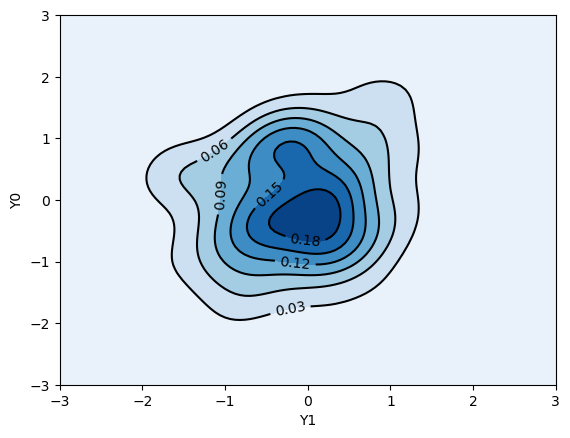

In [22]:
import numpy as np
import matplotlib.pyplot as pl
import scipy.stats as st

data = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x = data[:, 0]
y = data[:, 1]
xmin, xmax = -3, 3
ymin, ymax = -3, 3

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

fig = pl.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# Contourf plot
cfset = ax.contourf(xx, yy, f, cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot
#ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('Y1')
ax.set_ylabel('Y0')

pl.show()